In [1]:
!git clone https://github.com/shylane/pytorch-DL.git

Cloning into 'pytorch-DL'...
remote: Enumerating objects: 34, done.
remote: Counting objects: 100% (34/34), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 34 (delta 17), reused 26 (delta 9), pack-reused 0
Receiving objects: 100% (34/34), 13.69 KiB | 3.42 MiB/s, done.
Resolving deltas: 100% (17/17), done.


In [2]:
%pip install grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 18.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  U

PyTorch CIFAR10 Training


100%|██████████| 170498071/170498071 [00:03<00:00, 47311762.32it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
==> Preparing data..
==> Building model..

Epoch: 0


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


 [================================================================>]  Step: 1s276ms | Tot: 32s837ms | Loss: 2.125 | Acc: 26.465% (10586/40000) 313/313 


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


 [================================================================>]  Step: 33ms | Tot: 3s420ms | Loss: 1.687 | Acc: 36.290% (3629/10000) 100/100 
Saving..

Epoch: 1
 [================================================================>]  Step: 60ms | Tot: 32s43ms | Loss: 1.587 | Acc: 41.172% (16469/40000) 313/313 
 [================================================================>]  Step: 32ms | Tot: 3s419ms | Loss: 1.401 | Acc: 48.310% (4831/10000) 100/100 
Saving..

Epoch: 2
 [================================================================>]  Step: 54ms | Tot: 32s337ms | Loss: 1.398 | Acc: 49.305% (19722/40000) 313/313 
 [================================================================>]  Step: 36ms | Tot: 3s554ms | Loss: 1.240 | Acc: 55.230% (5523/10000) 100/100 
Saving..

Epoch: 3
 [================================================================>]  Step: 58ms | Tot: 32s307ms | Loss: 1.231 | Acc: 55.615% (22246/40000) 313/313 
 [======================================================

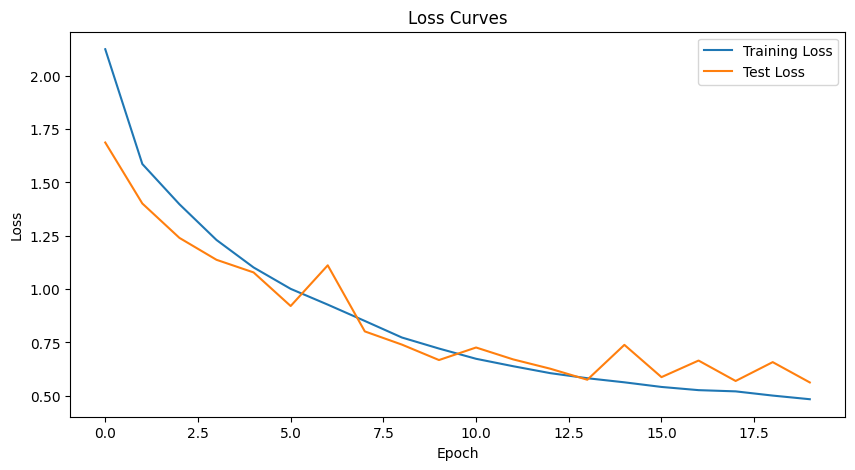

<Figure size 640x480 with 0 Axes>

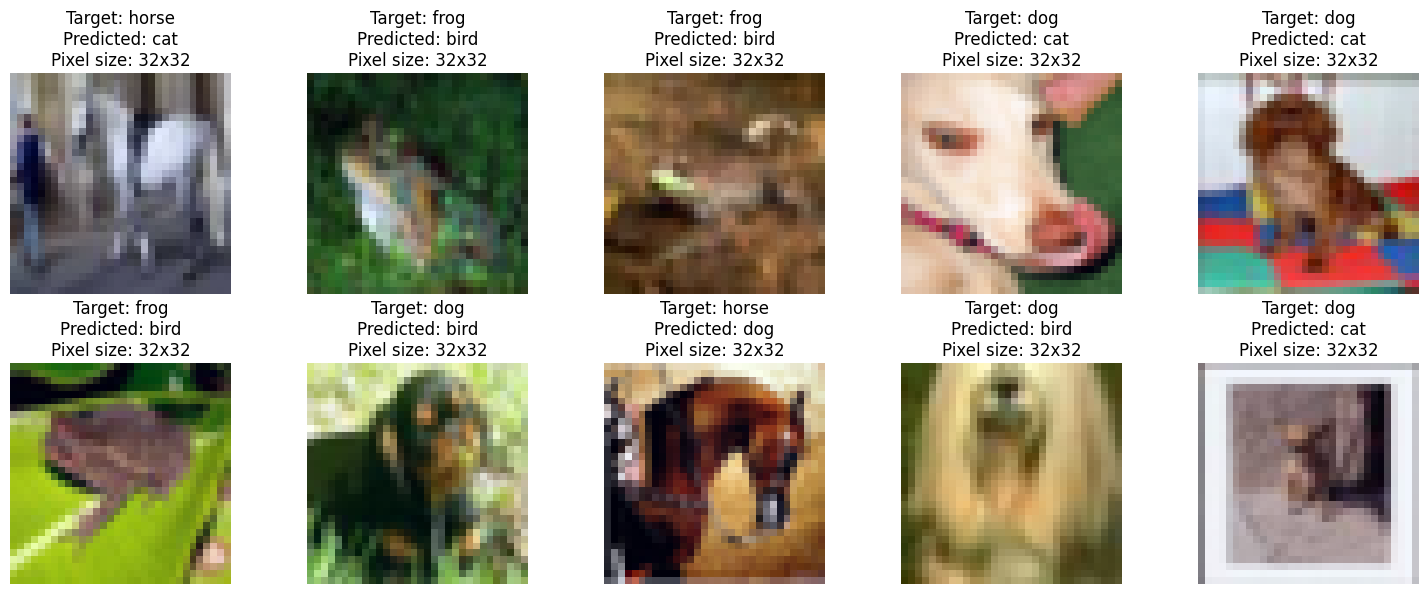

<Figure size 640x480 with 0 Axes>

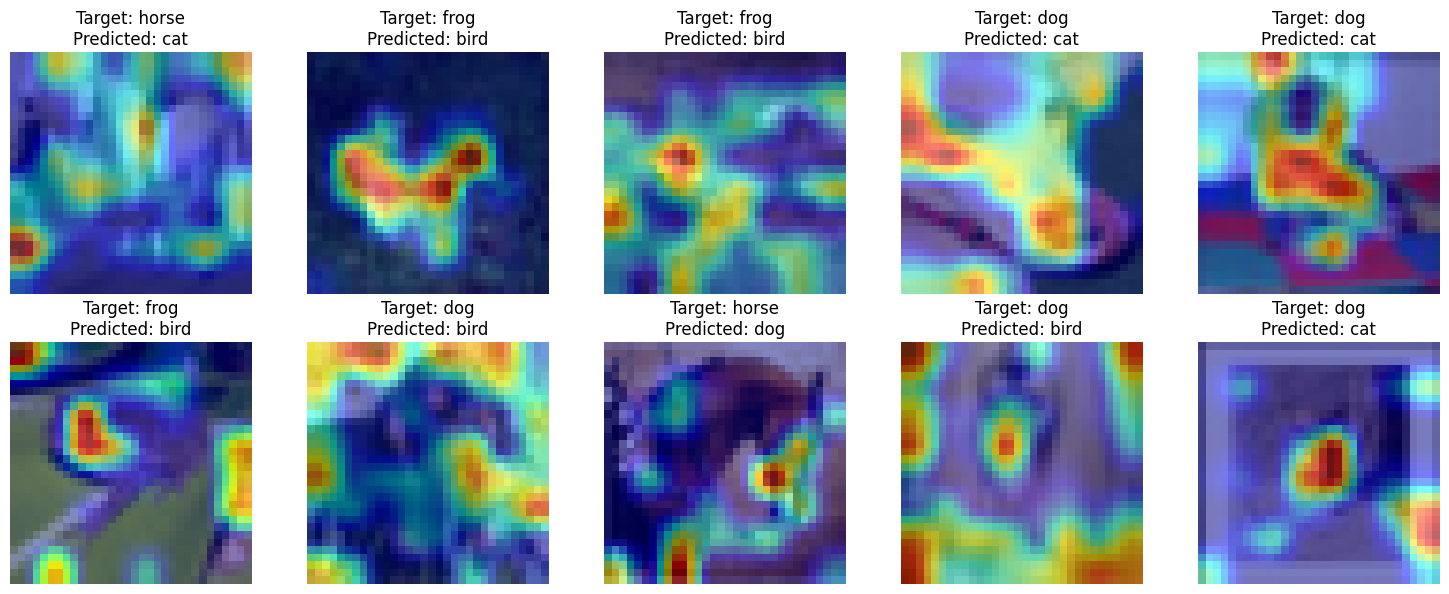

<Figure size 640x480 with 0 Axes>

In [3]:
import os
os.chdir('/content/pytorch-DL')
import sys
sys.path.append('.')
import torch
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
import torchvision


from models.resnet import ResNet18, ResNet34
from utils import misclassified_images,plot_gradcam,resume_from_checkpoint,plot_loss_curves
# Import the main module
from main import train,test,transform_data

# Run the main function with the provided arguments
print('PyTorch CIFAR10 Training')
lr=0.1 # learning rate
resume=False # resume from checkpoint
epochs=20 # number of epochs
batch_size=128 # mini-batch size
opt='sgd' # choices=['sgd', 'adam'] # optimizer to use
sch=True # use learning rate scheduler
model='ResNet18'# choices=['ResNet18', 'ResNet34'] # model to use
train_ratio=0.8 # ratio of train dataset
workers=2 # number of workers for dataloader

device = 'cuda' if torch.cuda.is_available() else 'cpu'
best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch

# Data
dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=None)
trainloader, testloader = transform_data(dataset,train_ratio=train_ratio, batch_size=batch_size, workers=workers)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Model
print('==> Building model..')
if model=='ResNet18':
    net = ResNet18()
else:
    net = ResNet34()
net = net.to(device)
if device == 'cuda':
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True

if resume:
    # Load checkpoint.
    best_acc, start_epoch = resume_from_checkpoint(net)

criterion = nn.CrossEntropyLoss()
if opt == 'sgd':
    optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
elif opt == 'adam':
    optimizer = optim.Adam(net.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

# Train and Test
train_losses = []
test_losses = []

for epoch in range(start_epoch, epochs):
    train_loss = train(net, trainloader, optimizer, criterion, device, epoch)
    test_loss = test(net, testloader, criterion, device, epoch, best_acc)
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    if sch:
        scheduler.step()

# Plot loss curves
plot_loss_curves(train_losses,test_losses,plot_file='LossCurve.png')

# Misclassified Images
misclassified = misclassified_images(net, testloader, classes, device, num_images=10, plot_file="misclassified.png")

# GradCAM
plot_gradcam(misclassified, net, device, classes, plot_file='gradcam.png')


In [ ]:
# Or run the following approach for passing arguments in command line
%run '/content/pytorch-DL/main.py' --epochs 20 --model Resnet18 --batch-size 128